In [1]:
#Import necessary libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#Load the data

df = pd.read_csv("AirPassengers.csv")

df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.shape

(144, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
#Time frame of the dataset

print("Start date:",df.min()[0])

print("End date:",df.max()[0])

Start date: 1949-01
End date: 1960-12


#### Data Transformation

In [6]:
#Format Date Variable

df["Month"] = pd.to_datetime(df["Month"],
                             format = "%Y-%m-%d")

In [7]:
#Renaming variables

df = df.rename(columns = {"Month": "ds",
                          "#Passengers": "y"})

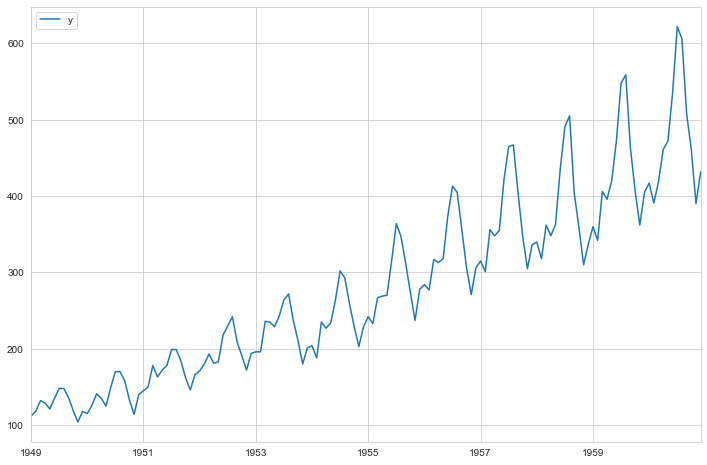

In [8]:
#Visualization

df.set_index("ds").plot(figsize = (12,8),
                        legend = True)

plt.xlabel(None);

#### Training and Test Sets

In [9]:
test_months = 12

training_set = df.iloc[:-test_months, :]

test_set = df.iloc[-test_months:, :]

#### Prophet

In [10]:
#Build and fit the model

m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = False,
            daily_seasonality = False,
            seasonality_mode = "multiplicative")

m.fit(training_set)

In [11]:
#Create future dataframe

future = m.make_future_dataframe(periods = test_months,
                                 freq = "MS")

In [12]:
#Forecast

forecast = m.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,1949-01-01,102.862147,90.784054,115.521889
1,1949-02-01,98.712503,86.282162,111.274785
2,1949-03-01,117.965650,104.453385,130.205141
3,1949-04-01,115.445146,102.519438,129.563012
4,1949-05-01,118.052204,104.596277,130.607935


In [13]:
#Predictions

prophet_predictions = pd.Series(forecast["yhat"][-test_months:].rename("prophet"))

prophet_predictions.index = test_set["ds"]

prophet_predictions

ds
1960-01-01    402.371463
1960-02-01    392.578467
1960-03-01    455.349104
1960-04-01    441.459379
1960-05-01    443.202746
1960-06-01    520.148355
1960-07-01    569.487003
1960-08-01    573.578381
1960-09-01    496.395279
1960-10-01    433.175028
1960-11-01    379.492734
1960-12-01    420.445224
Name: prophet, dtype: float64

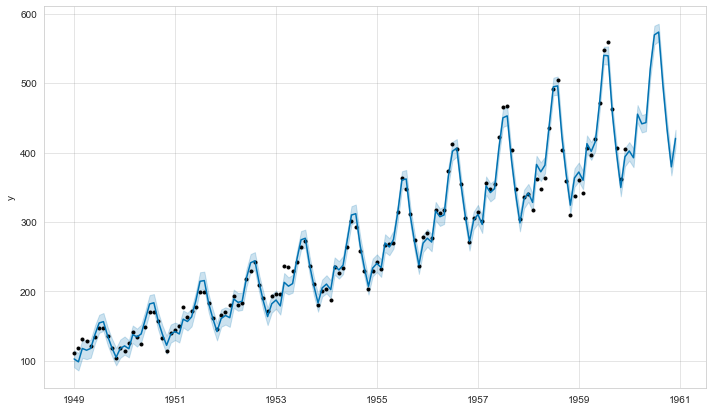

In [14]:
#Visualization forecast

m.plot(forecast)

plt.xlabel(None);

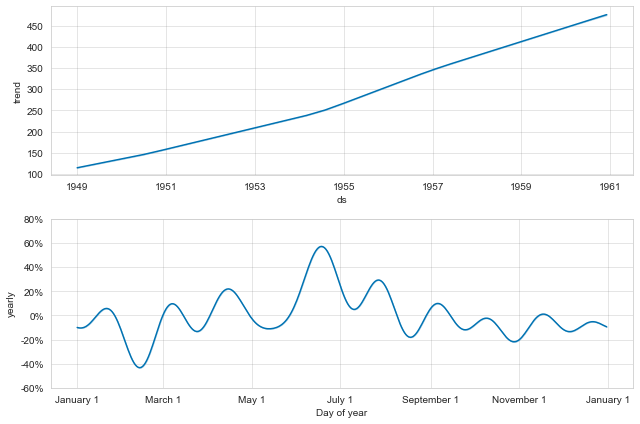

In [15]:
#Plot components

m.plot_components(forecast);

#### Model Evaluation

In [16]:
#MAE and RMSE

print("MAE:", round(mean_absolute_error(test_set["y"], prophet_predictions),2))
print("RMSE:", round(np.sqrt(mean_squared_error(test_set["y"], prophet_predictions)),2))

MAE: 21.85
RMSE: 25.71


In [17]:
#MAPE

def MAPE(y_true, y_preds):
    y_true, y_pred = np.array(y_true), np.array(y_preds)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAPE:",round(MAPE(test_set["y"], prophet_predictions),2))

MAPE: 4.43


#### Export Predictions

In [18]:
prophet_predictions.to_csv("AirPassengers_12Months_Forecast(Prophet).csv", index = True)